# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from prophet import Prophet
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime as dt
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
df = pd.read_excel("Dollor_Rate_Dataset.xlsx")
df.sort_index(ascending=False,inplace=True)
df = df.reset_index(drop=True)
df.drop("Persian_Date",axis=1,inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df[["Open","Low","High","Close"]] = df[["Open","Low","High","Close"]].replace(",","",regex=True)
df[["Open","Low","High","Close"]] = df[["Open","Low","High","Close"]].astype("int64")
df["Mean"] = round((df["Open"] + df["Close"]) / 2).astype("int64")
display(df)
print(df.info())

,Date,Open,Low,High,Close,Mean
0,2011-11-26,13700,13700,13700,13700,13700
1,2011-11-27,13440,13440,13440,13440,13440
2,2011-11-28,13350,13350,13350,13350,13350
3,2011-11-29,13400,13400,13400,13400,13400
4,2011-11-30,13500,13500,13500,13500,13500
...,...,...,...,...,...,...
3900,2024-07-21,577750,575000,579200,576110,576930
3901,2024-07-22,575850,574300,578700,575960,575905
3902,2024-07-23,579600,579320,583700,581760,580680
3903,2024-07-24,582970,582300,585200,584600,583785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3905 entries, 0 to 3904
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3905 non-null   datetime64[ns]
 1   Open    3905 non-null   int64         
 2   Low     3905 non-null   int64         
 3   High    3905 non-null   int64         
 4   Close   3905 non-null   int64         
 5   Mean    3905 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 183.2 KB
None


## Making datframe ready for Meta Prophet

In [3]:
df["ds"] = df["Date"]
df["y"] = df["Mean"]

# EDA(Exploratory Data Analysis) & Visualization

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Exchange Rate with Moving Averages</title>
</head>
<body>
    <h1>Exchange Rate with 30-Day, 90-Day & 365-Day Moving Averages</h1>
    <p>This plot shows the exchange rate of a currency pair over time. It includes:</p>
    <ul>
        <li><strong>Exchange Rate Line:</strong> The main line represents the daily exchange rate values.</li>
        <li><strong>30-Day Simple Moving Average (SMA30):</strong> A line that smooths the exchange rate by averaging the last 30 days, showing short-term trends.</li>
        <li><strong>90-Day Simple Moving Average (SMA90):</strong> A line that smooths the exchange rate by averaging the last 90 days, revealing longer-term trends.</li>
    </ul>
    <p><strong>Key Insights:</strong></p>
    <ul>
        <li><strong>Trends:</strong> SMA30 and SMA90 help identify short-term and long-term trends in the exchange rate.</li>
        <li><strong>Volatility:</strong> Comparing the exchange rate with the SMAs shows how stable or volatile the currency is.</li>
        <li><strong>Market Signals:</strong> Crossings between SMA30 and SMA90 may suggest buying or selling opportunities.</li>
    </ul>
</body>
</html>


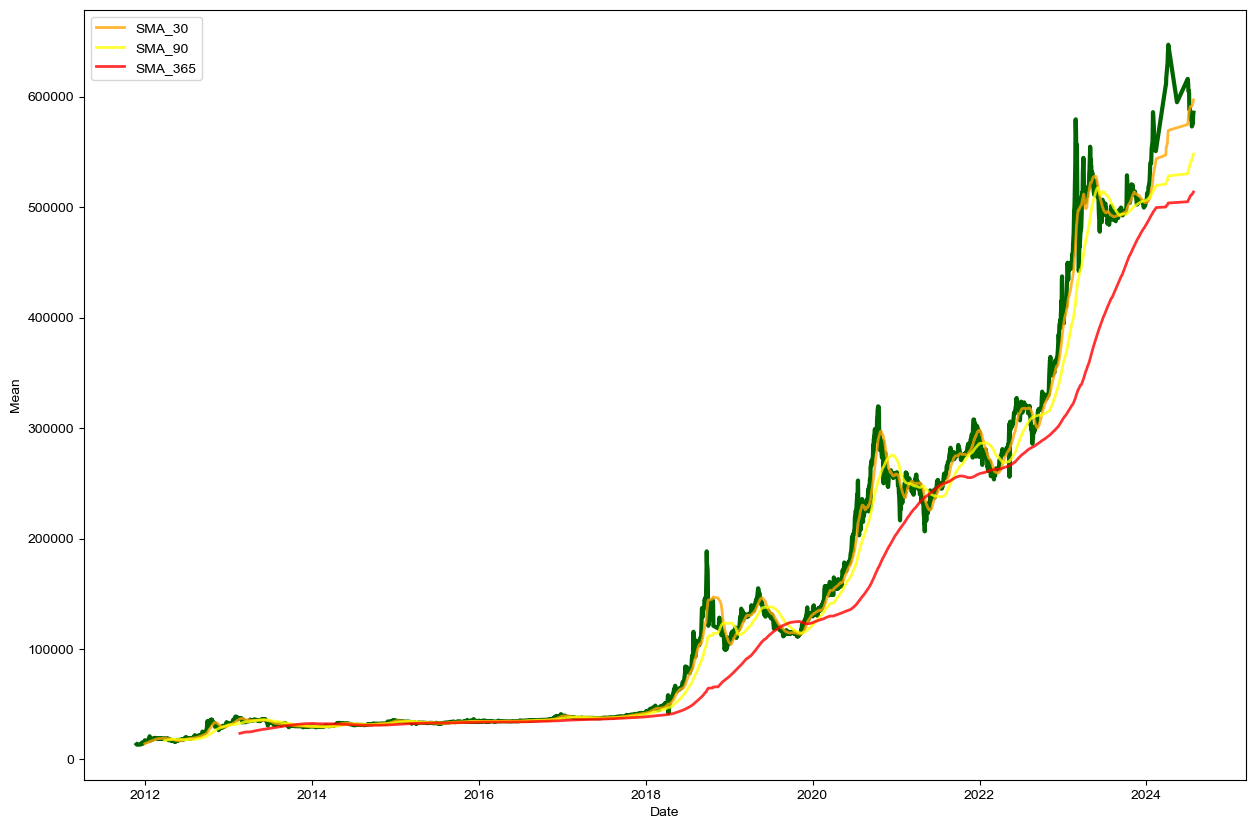

In [4]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=df["Date"],y=df["Mean"],color="darkgreen",linewidth = 3)
df['SMA_30'] = df['Mean'].rolling(window=30).mean()
df['SMA_90'] = df['Mean'].rolling(window=90).mean()
df['SMA_365'] = df['Mean'].rolling(window=365).mean()
sns.lineplot(x=df["Date"],y=df["SMA_30"],linewidth = 2,color="orange",alpha=0.8,label="SMA_30",markers="-")
sns.lineplot(x=df["Date"],y=df["SMA_90"],linewidth = 2,color="yellow",alpha=0.8,label="SMA_90",markers="-")
sns.lineplot(x=df["Date"],y=df["SMA_365"],linewidth = 2,color="red",alpha=0.8,label="SMA_365",markers="-")
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Polynomial Trendline Analysis</title>
</head>
<body>
    <h1>Polynomial Trendline Analysis</h1>
    <p>This plot displays the trendline fitting of a dataset using polynomial regressions of varying degrees, ranging from 1st to 22nd degree. The key components are:</p>
    <ul>
        <li><strong>Data Points:</strong> The plot shows the original data points for which the polynomial trendlines are fitted.</li>
        <li><strong>Polynomial Trendlines:</strong> Multiple trendlines are included, each representing a polynomial fit from degree 1 (linear) to degree 22 (highly complex). Each polynomial line is fitted to the data points to demonstrate how well different polynomial degrees capture the underlying trend.</li>
    </ul>
    <p><strong>Accuracy and Interpretation:</strong></p>
    <ul>
        <li><strong>Goodness of Fit:</strong> The accuracy of each polynomial trendline is assessed using metrics such as R-squared. Higher-degree polynomials often fit the data points more closely, but this does not always mean they are better for prediction, as they might overfit.</li>
        <li><strong>Overfitting:</strong> While higher-degree polynomials may have a higher accuracy on the training data, they can also lead to overfitting. This means they might capture noise rather than the true underlying trend.</li>
        <li><strong>Model Selection:</strong> It is crucial to balance fit and complexity. Polynomial degrees that are too high can result in a model that is too sensitive to the training data, while lower degrees may not capture the trend accurately enough.</li>
    </ul>
    <p>Overall, the polynomial trendline analysis helps in understanding how different degrees of polynomial regression can model the data and which degree provides the best balance between accuracy and generalizability.</p>
</body>
</html>


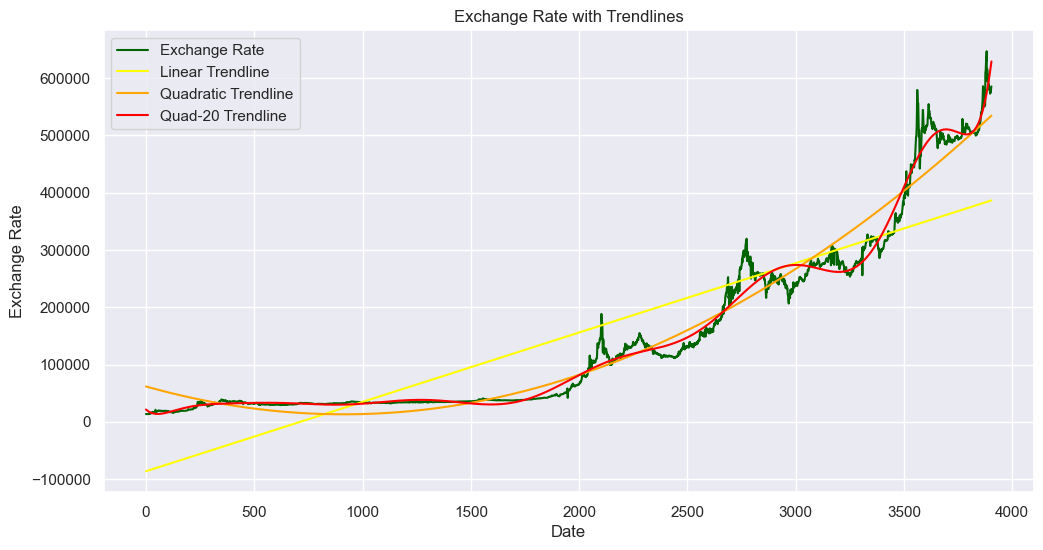

In [5]:
# Convert dates to numerical format
x = mdates.date2num(df.index)
y = df['Mean'].values

# Calculate linear trendline
linear_fit = np.polyfit(x, y, 1)  # Degree 1 for linear
linear_trendline = np.polyval(linear_fit, x)

# Calculate quadratic trendline
poly_fit = np.polyfit(x, y, 2)  # Degree 2 for quadratic
poly_trendline = np.polyval(poly_fit, x)

tri_fit = np.polyfit(x, y, 20)  # Degree 3 for quadratic
tri_trendline = np.polyval(tri_fit, x)

# Plot the original data and trendlines
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Mean'], label='Exchange Rate', color='darkgreen')
plt.plot(df.index, linear_trendline, label='Linear Trendline', color='yellow')
plt.plot(df.index, poly_trendline, label='Quadratic Trendline', color='orange')
plt.plot(df.index, tri_trendline, label='Quad-20 Trendline', color='red')

# Add titles and labels
plt.title('Exchange Rate with Trendlines')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

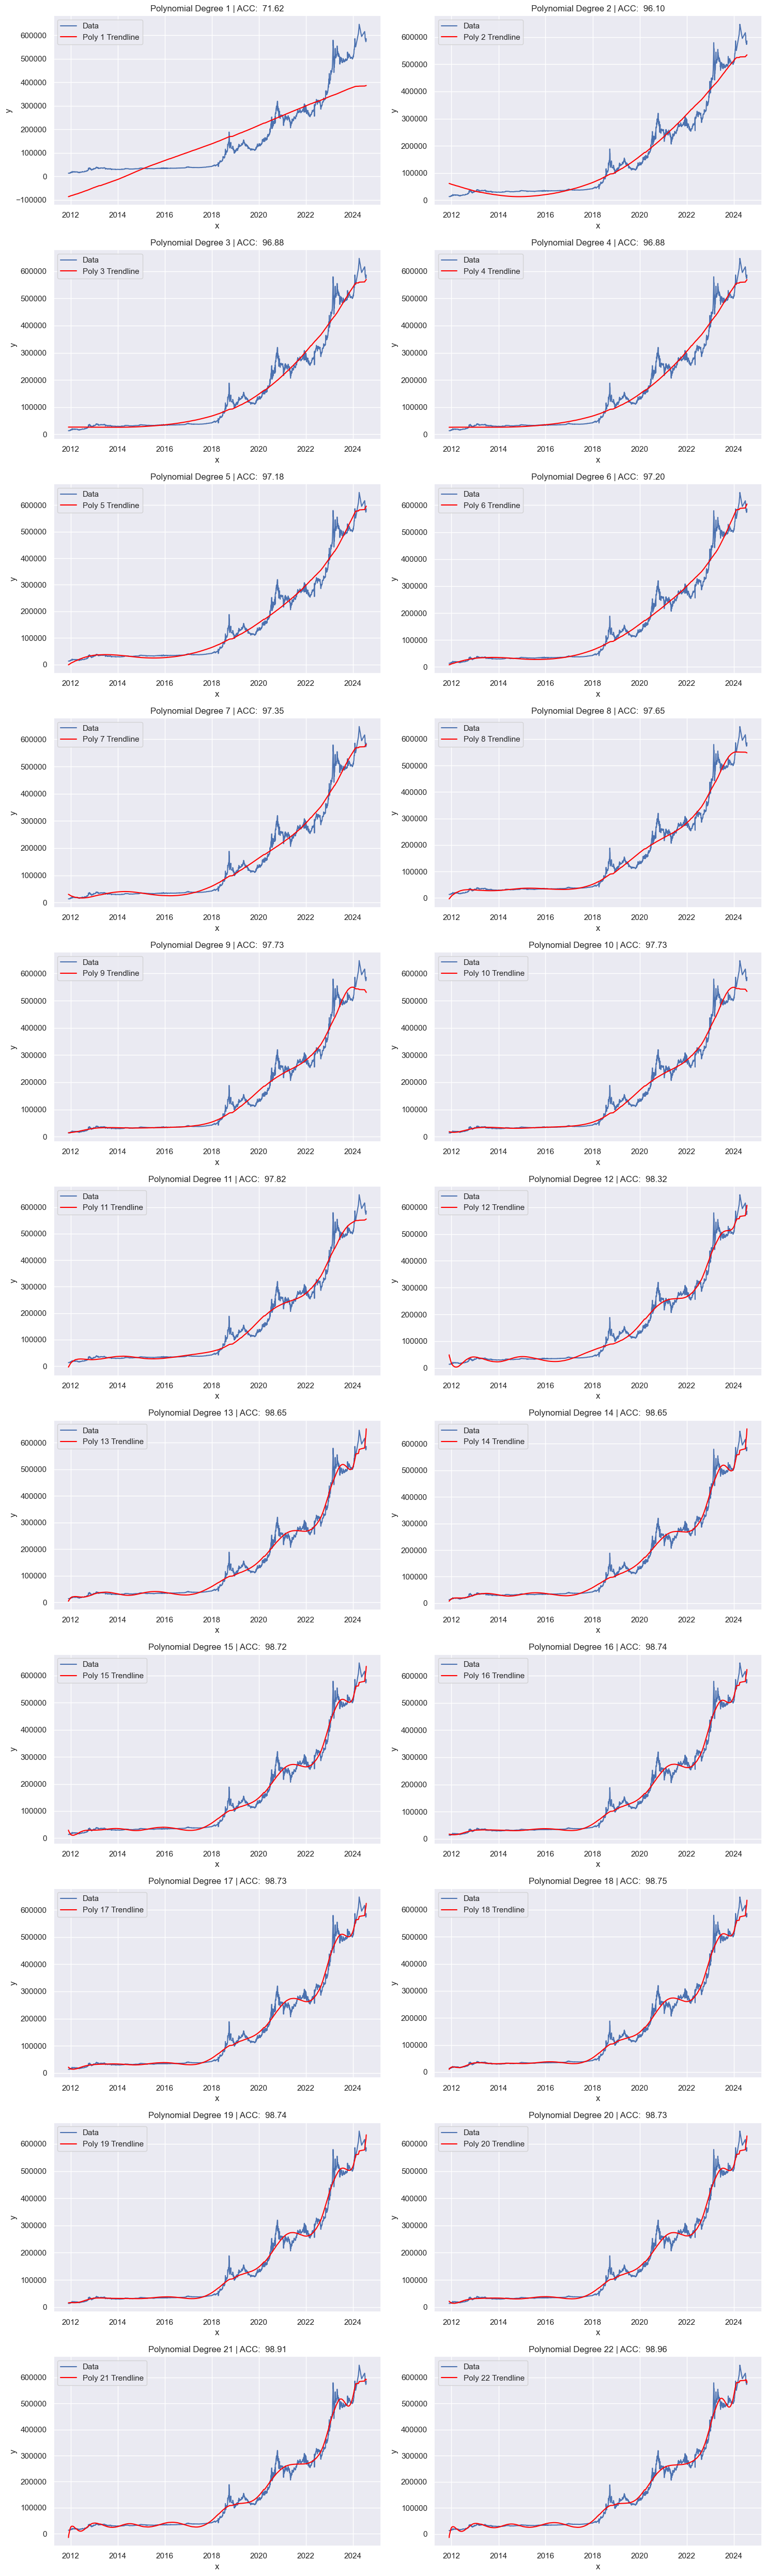

In [6]:
# Define the subplot grid
f, axes = plt.subplots(11, 2, figsize=(15, 50))  # Create a 15x3 grid
axes = axes.flatten()  # Flatten the 2D array to a 1D array for easy iteration

# Loop through each subplot
for i in range(1,23):
    # Fit a polynomial trendline of degree i
    fit = np.polyfit(x, y, i)
    trendline = np.polyval(fit, x)

    # Plot the data and trendline on the i-th subplot
    axes[i-1].plot(df['Date'], df['Mean'], '-', label='Data')
    axes[i-1].plot(df['Date'], trendline, label=f'Poly {i} Trendline', color='red')

    # Set the title and labels
    acc = r2_score(trendline,df["y"])
    axes[i-1].set_title(f'Polynomial Degree {i} | ACC: {acc*100: 2.2f}')
    axes[i-1].set_xlabel('x')
    axes[i-1].set_ylabel('y')
    axes[i-1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dollar Exchange Rate Regression Project</title>
    <style>
        h1 {
            color: red;
        }
    </style>
</head>
<body>
    <h1>Effect of BARJAM on Iranian Dollar Exchange Rate</h1>
    <p>
        This project analyzes the impact of the Joint Comprehensive Plan of Action (JCPOA), commonly known as BARJAM, on the exchange rate of the Iranian rial against the US dollar. BARJAM is an agreement reached between Iran and several world powers in 2015, aimed at curbing Iran's nuclear program in exchange for relief from international sanctions. The deal significantly affected Iran's economy and currency value due to changes in trade and financial relations. Our regression analysis explores how the implementation and changes in BARJAM influenced the fluctuations in the dollar exchange rate in Iran.
    </p>
</body>
</html>


In [7]:
xy_train = df.query('Date < "2018-05-01"')
xy_test = df.query('Date > "2018-05-01"')

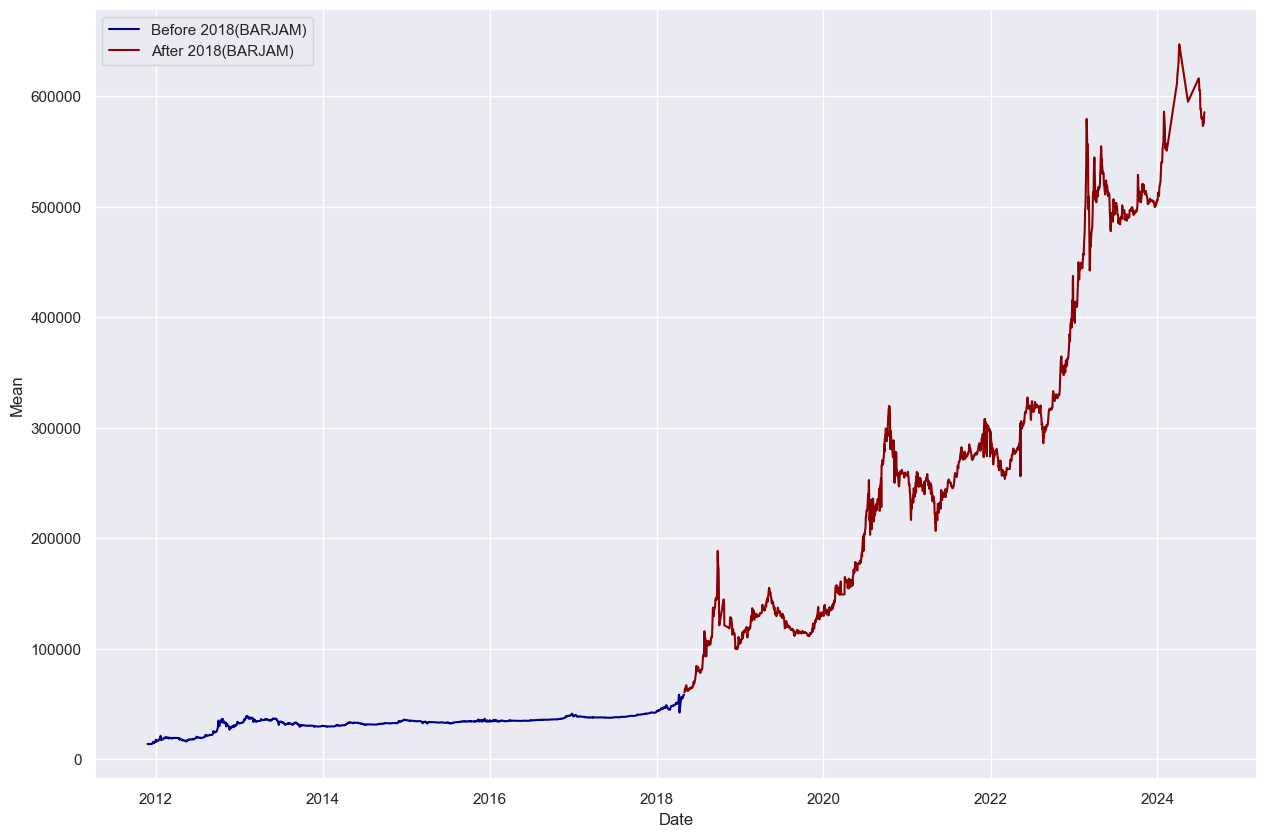

In [17]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=xy_train["Date"],y=xy_train["Mean"],color="darkblue",label="Before 2018(BARJAM)")
sns.lineplot(x=xy_test["Date"],y=xy_test["Mean"],color="darkred",label="After 2018(BARJAM)")
plt.legend(alignment="center")
plt.show()

In [18]:
m = Prophet(seasonality_mode="multiplicative",weekly_seasonality=True)
m.fit(xy_train[["ds","y"]])
xy_pred = m.predict(xy_train[["ds","y"]])[["ds","yhat"]]
print(r2_score(xy_train["y"],xy_pred["yhat"]))

06:36:27 - cmdstanpy - INFO - Chain [1] start processing
06:36:28 - cmdstanpy - INFO - Chain [1] done processing


0.9570318334162247


<p>Training Meta Prophet neural network on <b>2012</b> to <b>2018</b> daily dollor rate. As you see, the training is doing very well! <p>

<p>Training score on train set with the method of r_squared is:<b> 0.95 </b> <p>

<Axes: xlabel='Date', ylabel='Mean'>

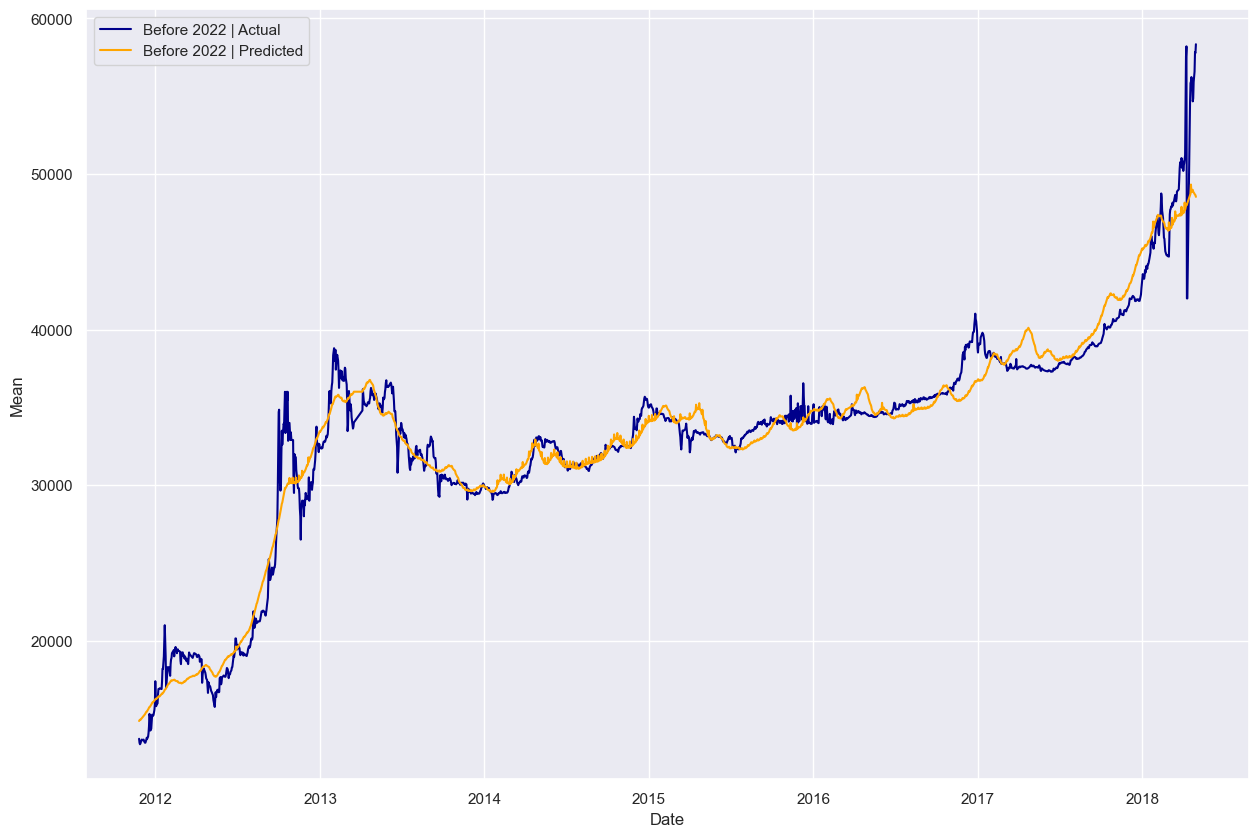

In [19]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=xy_train["Date"],y=xy_train["Mean"],color="darkblue",label="Before 2022 | Actual")
sns.lineplot(x=xy_pred["ds"],y=xy_pred["yhat"],color="orange",label="Before 2022 | Predicted")

# Impact of BARJAM on Iranian Dollar Exchange Rate

The following plot illustrates the projected exchange rate of the Iranian rial (IRR) against the US dollar (USD) by the end of 2024 under the scenario where the Joint Comprehensive Plan of Action (JCPOA), also known as BARJAM, had not been canceled. The plot demonstrates the significant impact that the continuation of BARJAM could have had on stabilizing the Iranian currency.

## Plot Description

The plot displays the predicted exchange rate in rials against the US dollar for the end of 2024 under two scenarios:

- **Scenario 1:** If BARJAM had been held and not canceled, the exchange rate would have been projected to reach approximately 10,000 rials per US dollar.
- **Scenario 2:** Without BARJAM, the exchange rate is projected to rise to around 60,000 rials per US dollar.

Additionally, the plot includes a prediction range showing the potential variability in the exchange rate:

- **Lower Bound:** Approximately 1,000 rials per US dollar, indicating the best-case scenario with significant stabilization.
- **Upper Bound:** Approximately 30,000 rials per US dollar, representing the worst-case scenario within the expected range.

This visualization highlights the substantial difference that maintaining BARJAM could make in stabilizing the exchange rate and underscores the uncertainty and potential range of outcomes if BARJAM had continued.

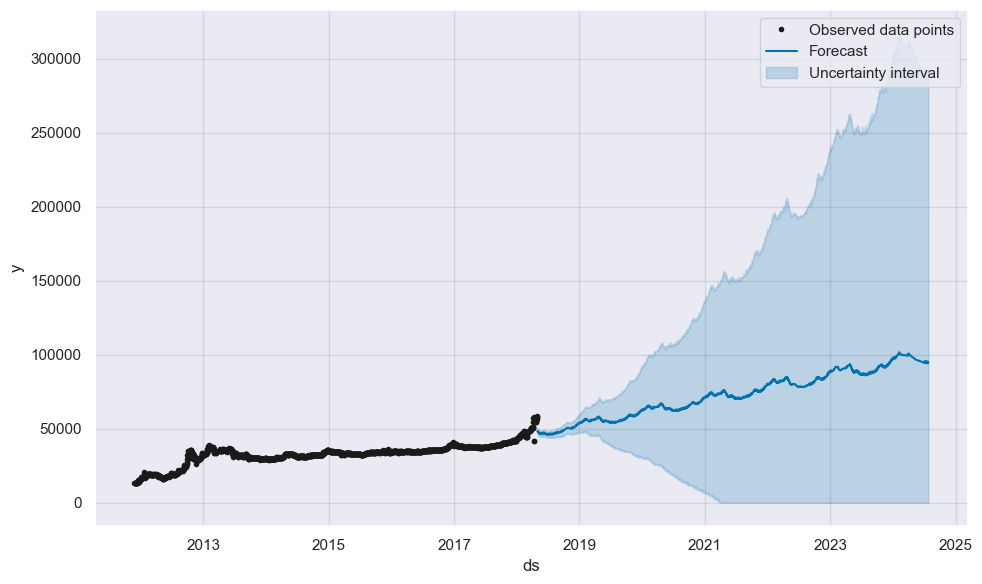

In [11]:
fcst = m.predict(xy_test)
un_fcst = fcst.copy()
for index, num in enumerate(un_fcst["yhat_lower"]):
    un_fcst["yhat_lower"][index] = np.maximum(num,0)
fig = m.plot(un_fcst,include_legend=True)

,ds,yhat
0,2018-05-02,48171.583166
1,2018-05-03,48576.717355
2,2018-05-04,47905.155571
3,2018-05-05,47803.013335
4,2018-05-06,47723.194358
...,...,...
1957,2018-04-25,48815.514122
1958,2018-04-27,48707.987962
1959,2018-04-28,48668.000131
1960,2018-04-29,48637.183305


Text(2018-06-01 00:00:00, 600000, '"Barjam" suspended')

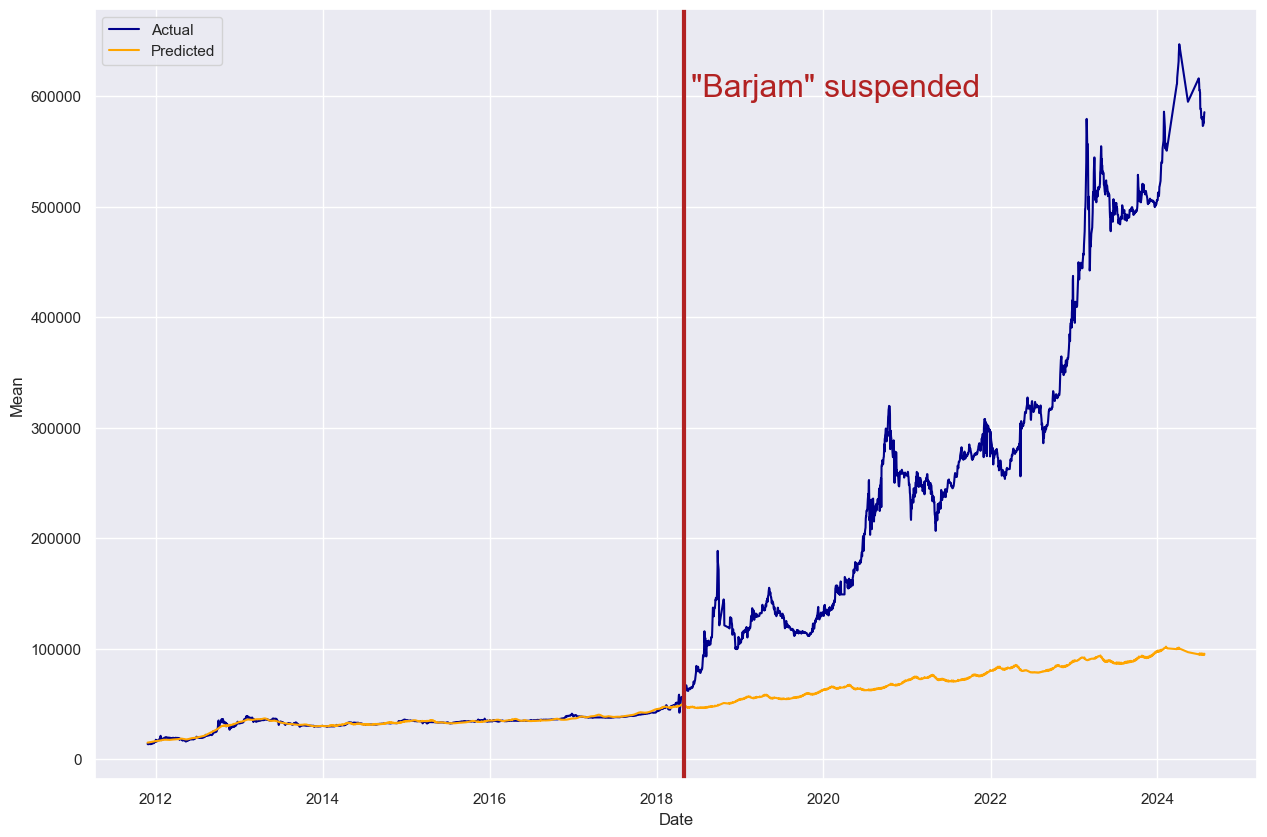

In [13]:
fig = plt.figure(figsize=(15,10))
xy_forecast = pd.concat([fcst,xy_pred])[["ds","yhat"]]
sns.lineplot(x=df["Date"],y=df["Mean"],color="darkblue",label="Actual")
sns.lineplot(x=xy_forecast["ds"],y=xy_forecast["yhat"],color="orange",label="Predicted")
plt.axvline(dt.datetime(2018, 5, 1),linewidth=3,color="firebrick")
plt.text(x=dt.datetime(2018, 6, 1),y=600000,s='"Barjam" suspended',fontsize=23,color="firebrick")

# Analysis of Dollar Exchange Rate Fluctuations

The following plot illustrates the fluctuations in the Iranian dollar exchange rate over time, highlighting the patterns of hype and subsequent downturns. The plot reveals a notable symmetry in the data, where periods of significant increase in the dollar rate are often followed by corresponding drops.

## Plot Description

The plot demonstrates the behavior of the dollar exchange rate with the following observations:

- **Symmetric Pattern:** The plot exhibits a symmetric pattern of fluctuations. Whenever the dollar rate experiences a sharp rise, it is frequently followed by a notable decrease. This symmetry suggests a cyclical behavior where the rate goes up significantly and then experiences a substantial drop.

- **Hype and Fluctuation:** The term "hype" in this context refers to the periods of rapid increases in the dollar rate, often driven by external or internal economic factors. Following these periods of hype, the rate tends to "dump," or drop, as the market adjusts or reacts to new information.

- **Volatility:** The plot highlights the volatility of the exchange rate, indicating that high volatility periods are characterized by extreme movements both upwards and downwards. This behavior underscores the sensitivity of the exchange rate to various economic pressures and market sentiment.

- **Cyclical Nature:** The plot suggests a potential cyclical nature in the exchange rate fluctuations, where periods of high rates are systematically followed by periods of correction or downturns. This cyclical pattern may be driven by market reactions, policy changes, or economic conditions.

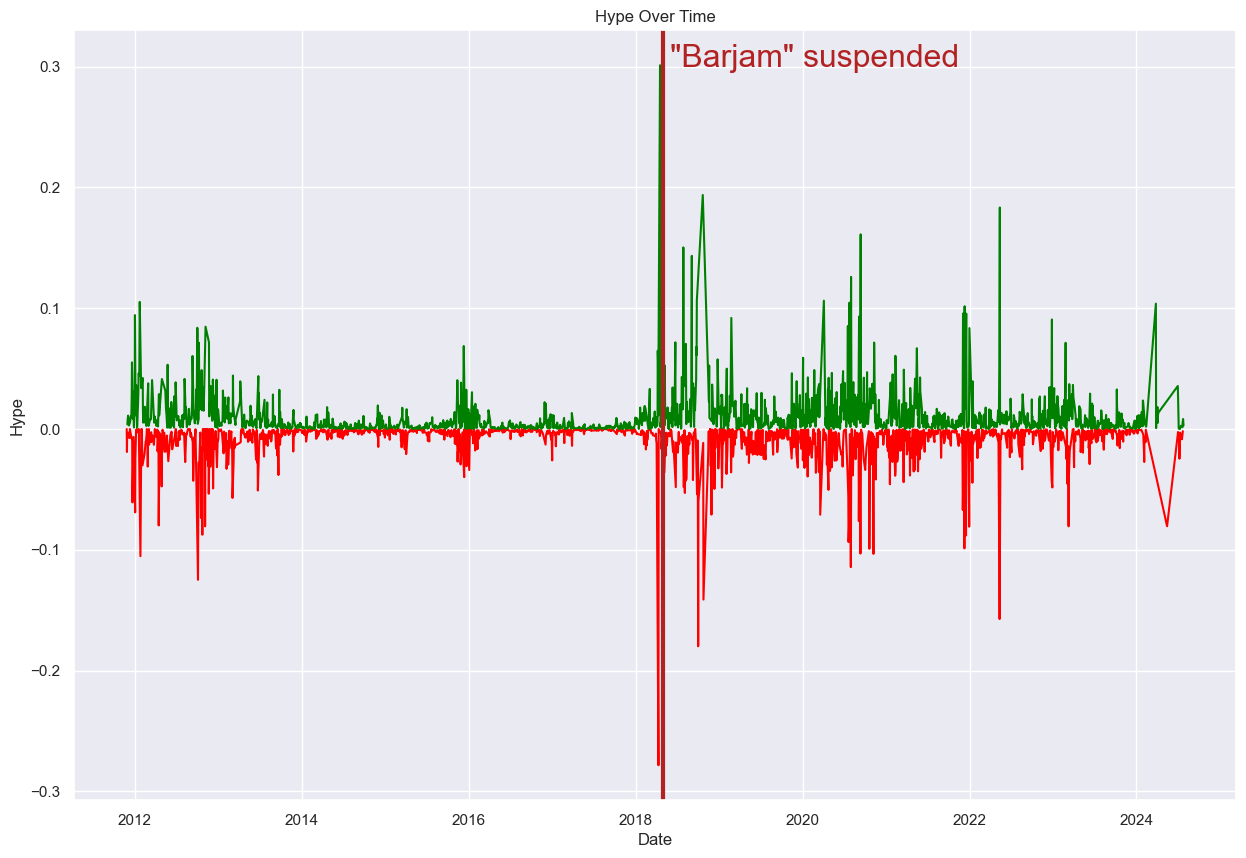

In [14]:
for index in range(len(df)):
    if index == 0:
        df["Hype"] = 0
    else:
        df["Hype"][index] = (df["Mean"][index] - df["Mean"][index-1])/df["Mean"][index-1]

# Create a column to determine positive and negative changes
df["positive"] = df["Hype"] > 0

# Plotting
fig = plt.figure(figsize=(15, 10))
sns.lineplot(x="Date", y="Hype", data=df, hue="positive", palette={True: 'green', False: 'red'}, legend=False)
plt.axvline(dt.datetime(2018, 5, 1), linewidth=3, color="firebrick")
plt.text(x=dt.datetime(2018, 6, 1), y=0.3, s='"Barjam" suspended', fontsize=23, color="firebrick")
plt.xlabel("Date")
plt.ylabel("Hype")
plt.title("Hype Over Time")
plt.show()

# Time Series Decomposition

In this analysis, we decompose the time series data using the `seasonal_decompose` function from the `statsmodels` library. Decomposition helps us understand the underlying components of the time series, including the trend, seasonal patterns, and residuals.

## Decomposition Details

We performed an additive decomposition of the time series data with a specified period of 365 days. The decomposition separates the series into four key components:

- **Original Series**: The raw time series data, which combines all the components.
- **Trend Component**: The underlying trend in the data, reflecting the long-term progression.
- **Seasonal Component**: The repeating, periodic fluctuations in the data, typically reflecting seasonal effects.
- **Residual Component**: The remaining noise or irregular components after removing the trend and seasonal effects.

## Plot Description

The following plots illustrate each component of the decomposition:

1. **Original Series**: Displays the raw time series data. This is the input data before any decomposition is applied.
2. **Trend Component**: Shows the trend extracted from the original series. It highlights the long-term movement or direction in the data.
3. **Seasonal Component**: Represents the seasonal variations within the data. This component captures the repeating patterns that occur at regular intervals.
4. **Residual Component**: Depicts the residuals, which are the variations left after removing the trend and seasonal effects. This component often includes noise or irregularities.

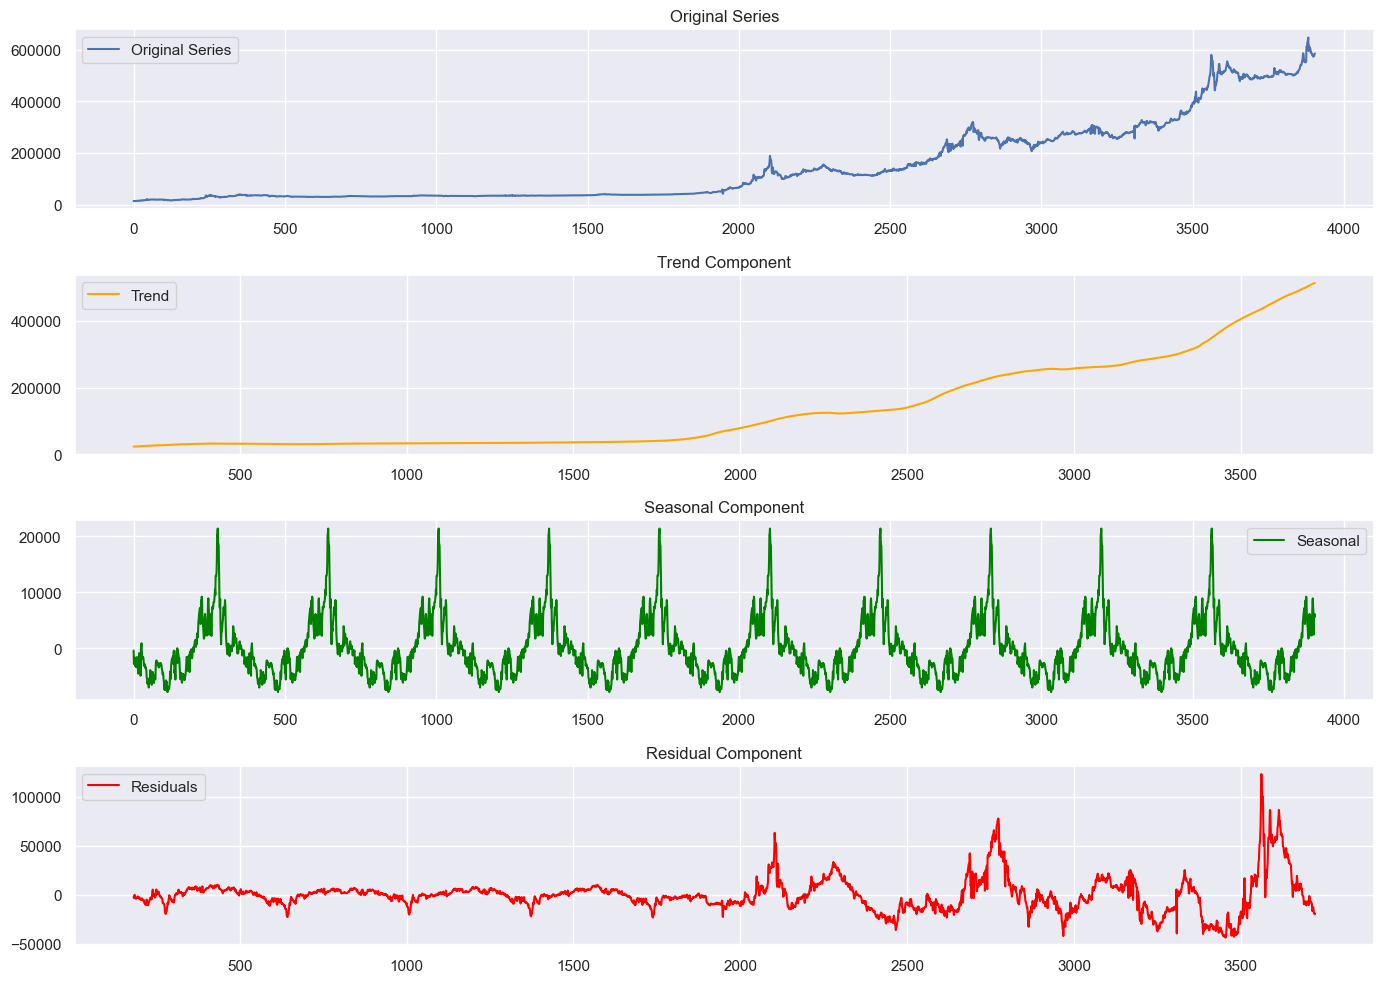

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Mean'], model='additive', period=365)  # Adjust period if needed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(14, 10))

# Plot the original series
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Mean'], label='Original Series')
plt.title('Original Series')
plt.legend(loc='best')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(df.index, trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend(loc='best')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(df.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend(loc='best')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(df.index, residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Autocorrelation and Partial Autocorrelation Analysis

In this analysis, we examine the autocorrelation and partial autocorrelation of the time series data. These plots help identify the correlation between observations at different lags and are crucial for selecting appropriate models for time series forecasting, such as ARIMA.

## Autocorrelation Function (ACF)

The Autocorrelation Function (ACF) measures the correlation of the time series with its own lagged values. It helps in identifying patterns of seasonality and determining how past values of the series are related to future values.

## Partial Autocorrelation Function (PACF)

The Partial Autocorrelation Function (PACF) measures the correlation between the time series and its lagged values, while controlling for the effects of intermediate lags. It is useful for identifying the order of autoregressive (AR) components in time series models.

## Plot Description

The following plots provide insights into the autocorrelation and partial autocorrelation of the time series:


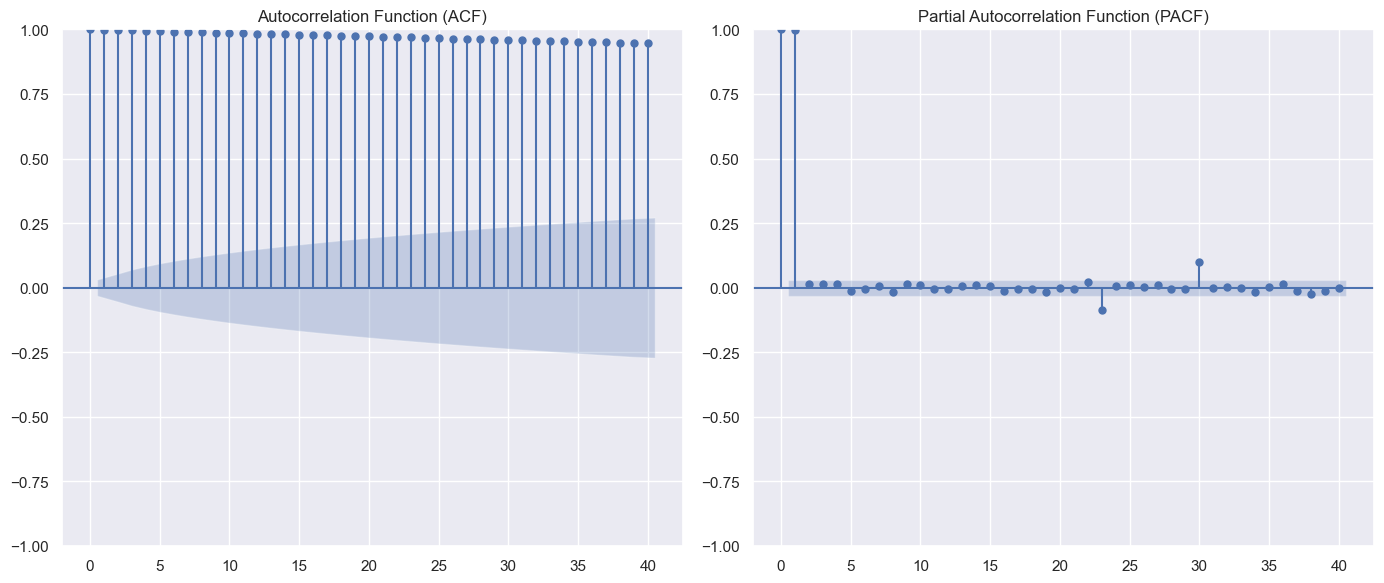

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the time series data
data = df['Mean']

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(data, ax=plt.gca(), lags=40)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(data, ax=plt.gca(), lags=40)  # Adjust lags as needed
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# ARIMA & SARIMAX wip